<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/03_nlp_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.6f}".format)

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

sns.set(style="whitegrid")

def plot_numeric(df, feature, label_col="label", bins=50, palette=None, auto_log=True):
  """
  Plot normalized histogram of a numeric feature by label.
  Automatically log-transforms highly skewed features if auto_log=True.
  """
  data = df.copy()
  plot_feature = feature

  # Determine if log-transform is needed
  if auto_log:
      feature_skew = skew(data[feature].dropna())
      if feature_skew > 2:
          plot_feature = "log_" + feature
          data[plot_feature] = np.log1p(data[feature])

  # Compute weights to normalize counts per label
  weights = data.groupby(label_col).transform(lambda x: 1 / len(x))

  plt.figure(figsize=(8, 5))
  sns.histplot(
      data=data,
      x=plot_feature,
      hue=label_col,
      bins=bins,
      weights=weights[feature],
      palette=palette or {"bot": "red", "human": "blue"},
      alpha=0.6
  )
  plt.xlabel(feature)
  plt.ylabel("Relative frequency")
  plt.title(f"{feature} by {label_col} (normalized)")
  plt.show()

def plot_boolean(df, feature, label_col="label", palette=None):
    """
    Plot relative proportions of a boolean feature by label.
    """

    # Compute proportions per label
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col,
        palette=palette or {"bot": "red", "human": "blue"}
    )

    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.title(f"{feature} by label")
    plt.show()

In [4]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/twibot-22/processed"

tweet_features = pd.read_parquet(f"{path}/tweet_features.parquet", engine='pyarrow')

In [5]:
n_rows, n_columns = tweet_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 1048873 rows and 11 columns.


In [6]:
tweet_features.head()

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,0,0,1,0.000000,0.000000,1,human
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,0,0,0,NaN,NaN,0,bot
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,0,0,0,NaN,NaN,1,bot
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,0,0,0,NaN,NaN,3,bot
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,0,0,0,NaN,NaN,44,bot


In [7]:
tweet_features.dtypes

,0
author_id,object
id,object
text,object
created_at,object
is_reply,int32
is_sensitive,int32
like_count,int64
quote_count,float64
reply_count,float64
retweet_count,int64


In [8]:
tweet_features["is_reply"] = tweet_features["is_reply"].astype(bool)
tweet_features["is_sensitive"] = tweet_features["is_sensitive"].astype(bool)

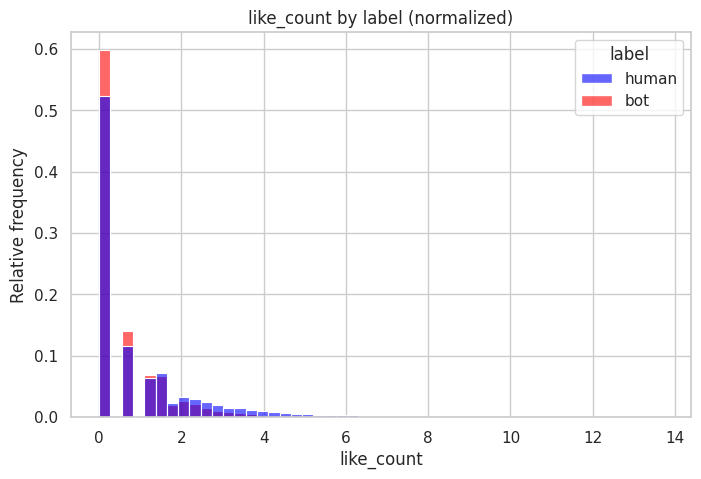

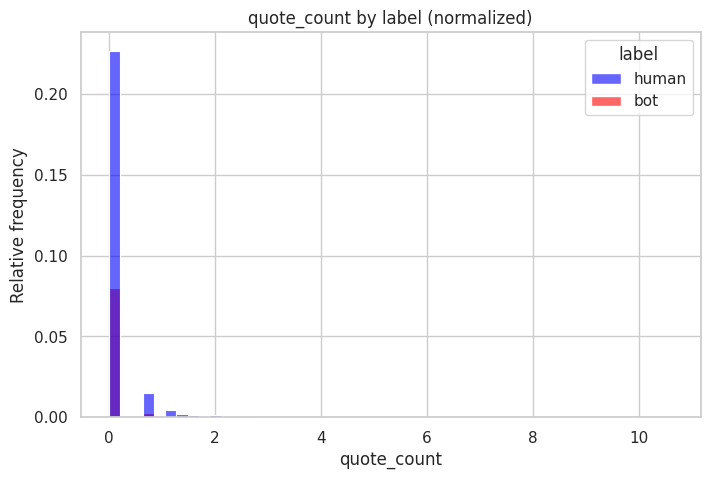

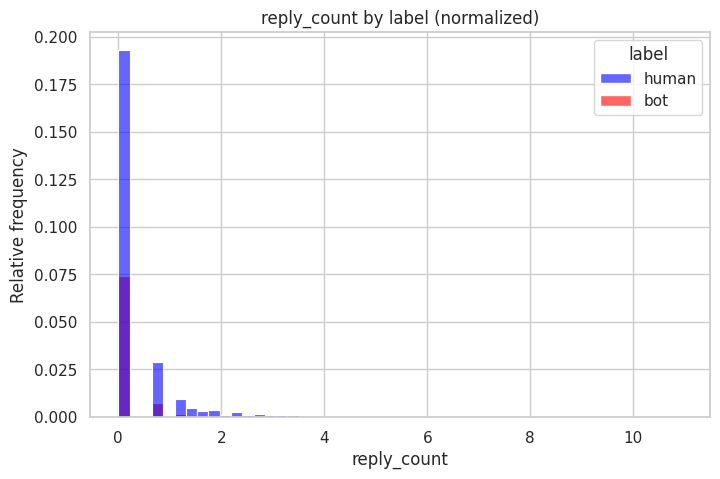

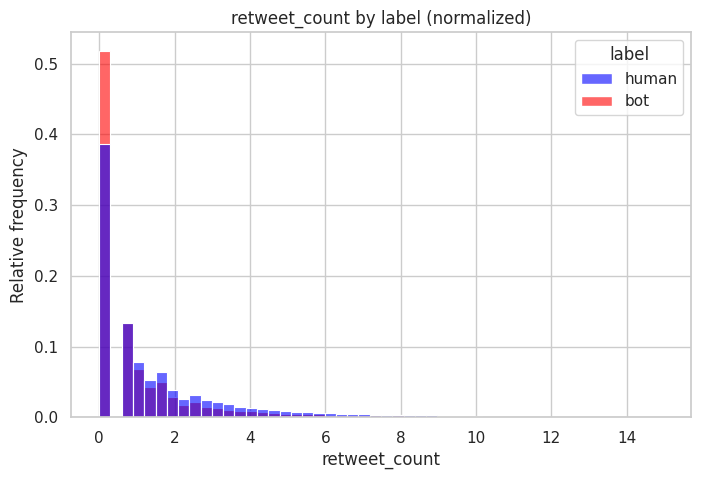

In [9]:
numeric_cols = tweet_features.select_dtypes(include=np.number).columns

for col in numeric_cols:
  plot_numeric(tweet_features, col)

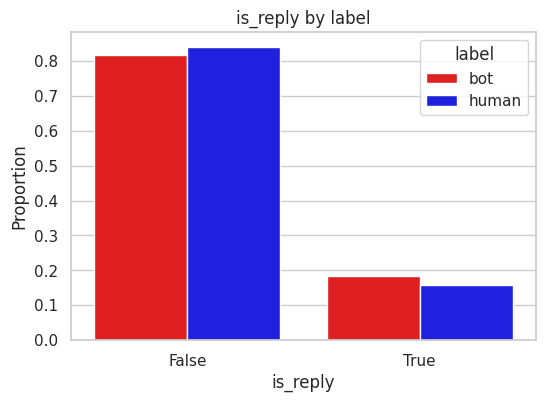

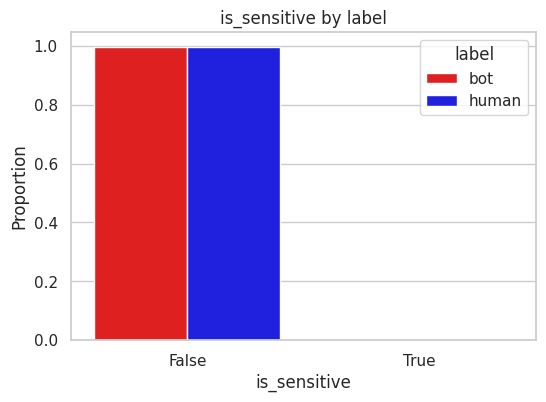

In [10]:
bool_cols = tweet_features.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(tweet_features, col)

In [11]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
             Missing Count  Missing Percentage
quote_count         796093           75.899847
reply_count         796093           75.899847


In [12]:
bots = tweet_features[tweet_features['label'] == 'bot']
humans = tweet_features[tweet_features['label'] == 'human']

def check_missing(df, label):
    if df.isnull().any().any():
        print(f"\nMissing values found for {label}:")
        na_summary = df.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
        na_summary['Missing Percentage'] = (na_summary['Missing Count'] / df.shape[0]) * 100
        print(na_summary)
    else:
        print(f"\nNo missing values found for {label}.")

check_missing(bots, "bots")
check_missing(humans, "humans")


Missing values found for bots:
             Missing Count  Missing Percentage
quote_count          86243           91.558910
reply_count          86243           91.558910

Missing values found for humans:
             Missing Count  Missing Percentage
quote_count         709850           74.354835
reply_count         709850           74.354835


In [13]:
for col in ['quote_count', 'reply_count']:
  tweet_features[f"{col}_missing"] = tweet_features[col].isnull().astype(bool)
  tweet_features[col] = tweet_features[col].fillna(0)

In [14]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [15]:
tweet_features.head()

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,False,False,1,0.000000,0.000000,1,human,False,False
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,False,False,0,0.000000,0.000000,0,bot,True,True
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,False,False,0,0.000000,0.000000,1,bot,True,True
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,False,False,0,0.000000,0.000000,3,bot,True,True
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,False,False,0,0.000000,0.000000,44,bot,True,True


In [16]:
tweet_features.dtypes

,0
author_id,object
id,object
text,object
created_at,object
is_reply,bool
is_sensitive,bool
like_count,int64
quote_count,float64
reply_count,float64
retweet_count,int64


In [22]:
from sklearn.model_selection import train_test_split

features = tweet_features.select_dtypes(include=[np.number, "bool"]).columns

tweet_features['label'] = tweet_features['label'].map({'human': 0, 'bot': 1})

X = tweet_features[features].copy()
y = tweet_features["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Predict
y_pred = clf.predict(X_test)

# Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = (y_pred == y_test).mean()

print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  0.9102
F1 score:  0.0001
Precision: 0.5000
Recall:    0.0001


In [25]:
tweet_features[tweet_features["author_id"] == "u1002590470097154048"]

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,False,False,0,NaN,NaN,0,bot
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,False,False,0,NaN,NaN,1,bot
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,False,False,0,NaN,NaN,3,bot
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,False,False,0,NaN,NaN,44,bot
5,u1002590470097154048,t1375413282966753290,<USER> <USER> <USER> <USER> Congratulations Weijia🎉,2021-03-26 11:44:15+00:00,True,False,1,NaN,NaN,0,bot
6,u1002590470097154048,t1375413169594699778,"RT <USER>: A guiding vector field is typically used for the guidance of a single vehicle. I, with <USER>, <USER>, <USER>…",2021-03-26 11:43:48+00:00,False,False,0,NaN,NaN,3,bot
7,u1002590470097154048,t1346466348134633477,RT <USER>: Our <USER> <USER> new #robot navigation #algorithm uses singularity-free guiding vector fields <URL>,2021-01-05 14:39:28+00:00,False,False,0,NaN,NaN,4,bot
8,u1002590470097154048,t1278585165229547520,RT <USER>: The papers I covered:\nD4RL (benchmarks): <URL>\nCQL (lower bound algorithm): <URL>\nAWAC (s…,2020-07-02 07:03:53+00:00,False,False,0,NaN,NaN,10,bot
9,u1002590470097154048,t1278585146254467073,"RT <USER>: Offline reinforcement learning talk, which I prepared for a seminar at Google -- here is a recording I made (while rehearsing…",2020-07-02 07:03:48+00:00,False,False,0,NaN,NaN,61,bot
10,u1002590470097154048,t1085150128917413888,Conference Deadlines 😺<URL>,2019-01-15 12:22:06+00:00,False,False,0,NaN,NaN,0,bot


In [ ]:
# Cast label column: 1 if "bot", 0 if "human"
tweet_features['label'] = tweet_features['label'].map({'human': 0, 'bot': 1})

In [ ]:
user_features.head(1)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label
0,u1000012406,25,8,0.320000,LAYING THAT PIPE DOWN\n\n ...,147,True,True,True,False,True,True,False,False,0.000000,0.000000,0.000000,0.160000,0.000000,0.068027,17.000000,0.333333,4.083856,2.750000,0.920000,0.499500,0,0,0,0,False,False,412024425,370,533,0,13642,0.694184,1.388368,1.440541,0.003893,0.590255,0.000000,36.870270,0.000000,0.000001,0.000001,0.000000,0.000033,0


In [ ]:
# Count human and bot accounts
human_count = (user_features['label'] == 0).sum()
bot_count = user_features.shape[0] - human_count

human_pct = human_count / user_features.shape[0] * 100
bot_pct = bot_count / user_features.shape[0] * 100

print(f"Number of human accounts: {human_count} ({human_pct:.2f}%)")
print(f"Number of bot accounts: {bot_count} ({bot_pct:.2f}%)")

Number of human accounts: 256406 (92.16%)
Number of bot accounts: 21821 (7.84%)


In [ ]:
# Separate features (X) and target (y)
X = user_features.drop(columns=['id', 'label'])
y = user_features['label']

In [ ]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64'), dtype('O'), dtype('bool'),
       dtype('float32'), dtype('int64')], dtype=object)

In [ ]:
n_features = X.shape[1]

numeric_cols = X.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns
text_cols = X.select_dtypes(include=['O']).columns

numeric_bool_cols = numeric_cols.append(bool_cols)

print(f"There are {n_features} features: {len(numeric_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 48 features: 37 numeric, 10 boolean, 1 text/object.


In [ ]:
from sklearn.model_selection import train_test_split

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

In [ ]:
def report_split(y, split_name):
    n = len(y)
    pct = n / len(user_features) * 100
    class_counts = y.value_counts()
    class_pct = y.value_counts(normalize=True) * 100

    print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
    for cls in class_counts.index:
        print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
    print("-" * 40)

report_split(y_train, "Training")
report_split(y_test, "Test")

Training set: 250404 rows (90.00% of dataset)
  Class 0: 230765 rows (92.16%)
  Class 1: 19639 rows (7.84%)
----------------------------------------
Test set: 27823 rows (10.00% of dataset)
  Class 0: 25641 rows (92.16%)
  Class 1: 2182 rows (7.84%)
----------------------------------------


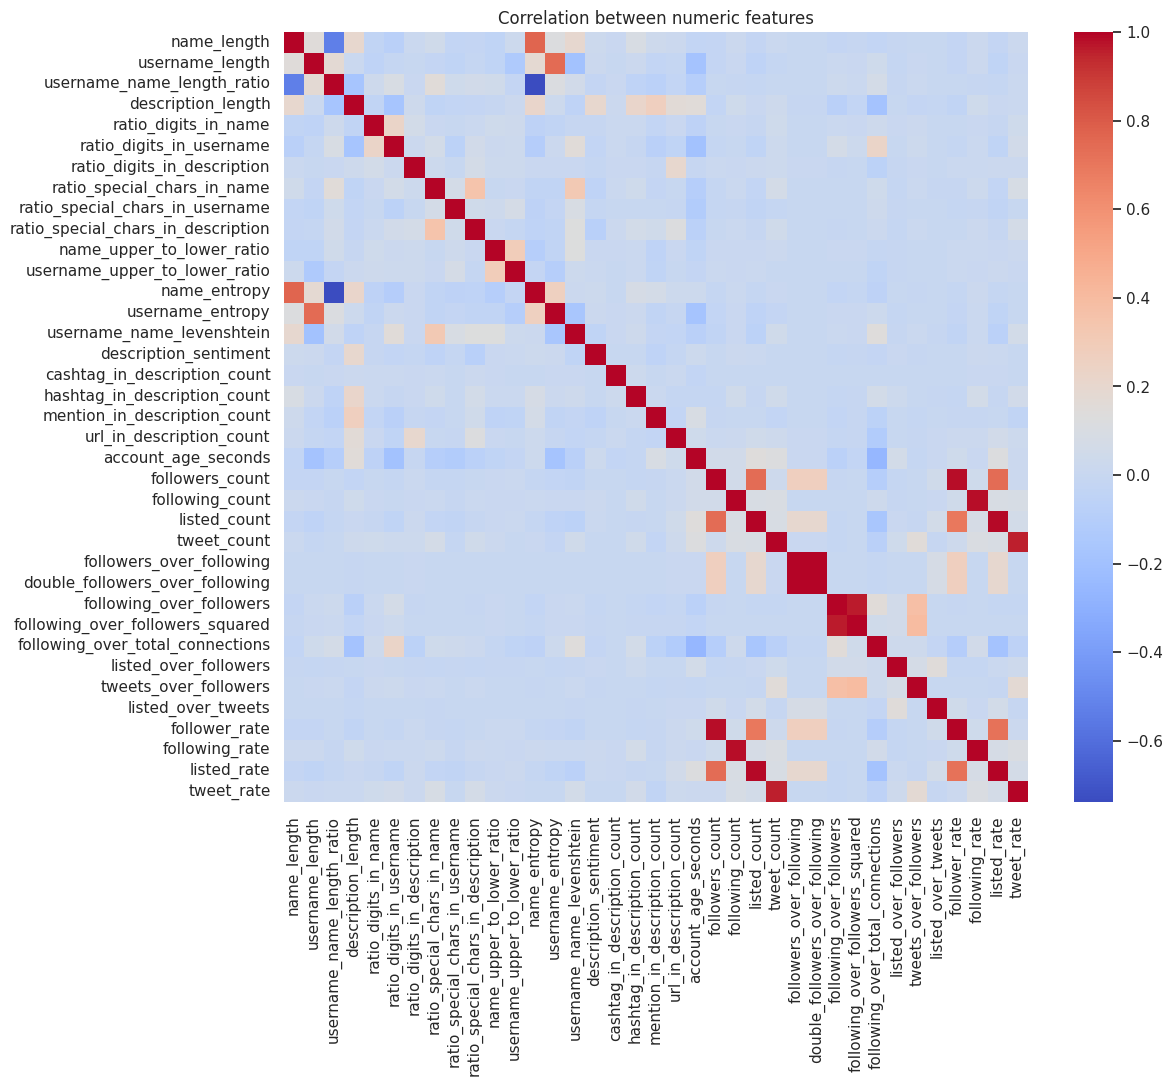

In [ ]:
# Check pairwise correlations between numeric features
corr_matrix = X_train[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

In [ ]:
from itertools import combinations

threshold = 0.8
high_corr = []

for col1, col2 in combinations(numeric_cols, 2):
    corr_val = corr_matrix.loc[col1, col2]
    if abs(corr_val) > threshold:
        high_corr.append((col1, col2, corr_val))

print("Highly correlated pairs (|| > 0.8):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} - {col2}: {corr_val:.2f}")

Highly correlated pairs (|| > 0.8):
followers_count - follower_rate: 0.98
following_count - following_rate: 0.98
listed_count - listed_rate: 0.99
tweet_count - tweet_rate: 0.95
followers_over_following - double_followers_over_following: 1.00
following_over_followers - following_over_followers_squared: 0.96


In [ ]:
# Check for numeric/boolean features with low variance
variances = X_train[numeric_bool_cols].var()

low_variance = variances[variances < 0.01].sort_values()

print("Features with variance < 0.01:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.01:
has_username: 0.000000
listed_rate: 0.000000
following_rate: 0.000000
tweet_rate: 0.000000
follower_rate: 0.000004
has_name: 0.000016
ratio_digits_in_description: 0.000733
has_bot_word_in_name: 0.001013
ratio_digits_in_name: 0.001428
has_bot_word_in_description: 0.001838
ratio_special_chars_in_username: 0.001894
is_protected: 0.001953


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

class SentenceEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", chunk_size=60000):
      self.model_name = model_name
      self.model = SentenceTransformer(self.model_name)

      self.chunk_size = chunk_size

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      if isinstance(X, pd.Series):
        X = X.values

      first_elem = X[0]
      out = np.empty((len(X), 1), dtype=object)

      if isinstance(first_elem, np.ndarray):
        for start in range(0, len(X), self.chunk_size):
          end = min(start + self.chunk_size, len(X))
          batch = X[start:end]

          all_tweets = list(itertools.chain.from_iterable(batch))

          all_embeddings = self.model.encode(all_tweets, batch_size=1024, show_progress_bar=True, device=device)

          lengths = [len(lst) for lst in batch]
          splits = np.cumsum(lengths)[:-1]
          grouped = np.split(all_embeddings, splits)

          mean_embs = np.array([g.mean(axis=0) for g in grouped])
          out[start:end, 0] = list(mean_embs)

          torch.cuda.empty_cache()

      else:
        embeddings = self.model.encode(X, batch_size=1024, show_progress_bar=True, device=device)  # (n_samples, embedding_dim)
        out[:, 0] = list(embeddings)

      torch.cuda.empty_cache()

      return out

In [ ]:
desc_column = text_cols[0]
desc_embedding_model = "all-MiniLM-L6-v2"

'''
tweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]

if lang_version[1:] == "all_lang":
    desc_embedding_model = "distiluse-base-multilingual-cased-v1"

    if embedding_version[1:] in ["v1", "v3"]:
        tweet_embedding_model = "distiluse-base-multilingual-cased-v1"
    elif embedding_version[1:] in ["v2", "v4"]:
        tweet_embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"

elif lang_version[1:] == "en":
    desc_embedding_model = "all-MiniLM-L6-v2"

    if embedding_version[1:] in ["v1", "v3"]:
        tweet_embedding_model = "all-MiniLM-L6-v2"
    elif embedding_version[1:] in ["v2", "v4"]:
        tweet_embedding_model = "paraphrase-MiniLM-L6-v2"
'''

'\ntweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]\n\nif lang_version[1:] == "all_lang":\n    desc_embedding_model = "distiluse-base-multilingual-cased-v1"\n\n    if embedding_version[1:] in ["v1", "v3"]:\n        tweet_embedding_model = "distiluse-base-multilingual-cased-v1"\n    elif embedding_version[1:] in ["v2", "v4"]:\n        tweet_embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"\n\nelif lang_version[1:] == "en":\n    desc_embedding_model = "all-MiniLM-L6-v2"\n\n    if embedding_version[1:] in ["v1", "v3"]:\n        tweet_embedding_model = "all-MiniLM-L6-v2"\n    elif embedding_version[1:] in ["v2", "v4"]:\n        tweet_embedding_model = "paraphrase-MiniLM-L6-v2"\n'

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold=0  # "median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),
#    ("desc_text_embedding", SentenceEmbedder(f"sentence-transformers/{desc_embedding_model}"), desc_column),
#    ("tweet_text_embedding", SentenceEmbedder(f"sentence-transformers/{tweet_embedding_model}"), tweet_column)
    ], remainder="drop")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)

'\nfrom sklearn.feature_selection import VarianceThreshold, SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\n\nnumeric_bool_pipeline = Pipeline([\n    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01\n    ("model_sel", SelectFromModel(\n        GradientBoostingClassifier(n_estimators=100, random_state=42),\n        threshold="median"  # keep features above median importance\n    ))\n])\n\npreprocessor = ColumnTransformer([\n    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),\n    ("desc_text_embedding", SentenceEmbedder(f"sentence-transformers/{desc_embedding_model}"), desc_column),\n    ("tweet_text_embedding", SentenceEmbedder(f"sentence-transformers/{tweet_embedding_model}"), tweet_column)\n    ], remainder="drop")\n\n# Fit on training set\npreprocessor.fit(X_train, y_train)\n\n# Transform train/test sets\nX_tra

In [ ]:
'''
np.save(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", X_train_selected)
np.save(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", X_test_selected)
'''

'\nnp.save(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", X_train_selected)\nnp.save(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", X_test_selected)\n'

In [ ]:
'''
import joblib

numeric_bool_pipeline_fitted = preprocessor.named_transformers_['numeric_bool_pipeline']
joblib.dump(numeric_bool_pipeline_fitted, f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")
'''

'\nimport joblib\n\nnumeric_bool_pipeline_fitted = preprocessor.named_transformers_[\'numeric_bool_pipeline\']\njoblib.dump(numeric_bool_pipeline_fitted, f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")\n'

In [ ]:
'''
metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": desc_column,
    "tweet_column": tweet_column,
    "desc_embedding_model": desc_embedding_model,
    "tweet_embedding_model": tweet_embedding_model
}

metadata_df = pd.DataFrame([metadata])
metadata_df.to_csv(f"{path}{lang_version}{embedding_version}/metadata.csv", index=False)
'''

'\nmetadata = {\n    "lang_version": lang_version[1:],\n    "embedding_version": embedding_version[1:],\n    "desc_column": desc_column,\n    "tweet_column": tweet_column,\n    "desc_embedding_model": desc_embedding_model,\n    "tweet_embedding_model": tweet_embedding_model\n}\n\nmetadata_df = pd.DataFrame([metadata])\nmetadata_df.to_csv(f"{path}{lang_version}{embedding_version}/metadata.csv", index=False)\n'

In [ ]:
import numpy as np

X_train_selected = np.load(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", allow_pickle=True)
X_test_selected = np.load(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", allow_pickle=True)

In [ ]:
import joblib

numeric_bool_pipeline_fitted = joblib.load(f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")

In [ ]:
desc_column = text_cols[0]
tweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]

var_mask = numeric_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = numeric_bool_cols[var_mask]

sfm = numeric_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
numeric_bool_cols_selected = cols_after_var[model_mask]

all_selected_cols = list(numeric_bool_cols_selected) + [desc_column, tweet_column]

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols, index=X_test.index)

# Restore feature types
numeric_cols_selected = [col for col in numeric_bool_cols_selected if col in numeric_cols]
bool_cols_selected = [col for col in numeric_bool_cols_selected if col in bool_cols]

X_train_selected_df[numeric_cols_selected] = X_train_selected_df[numeric_cols_selected].astype(float)
X_test_selected_df[numeric_cols_selected] = X_test_selected_df[numeric_cols_selected].astype(float)

X_train_selected_df[bool_cols_selected] = X_train_selected_df[bool_cols_selected].astype(int)
X_test_selected_df[bool_cols_selected] = X_test_selected_df[bool_cols_selected].astype(int)

In [ ]:
X_train.head(2)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
15895,13,12,0.923077,"Artists in conversation, since 1981. Quarterly...",75,True,True,True,True,True,True,False,False,0.000000,0.000000,0.053333,0.000000,0.000000,0.053333,0.714286,0.500000,3.238901,3.251629,0.153846,0.000000,0,0,0,0,False,True,527508167,56424,2666,1961,16118,21.164291,42.328582,0.047249,0.000001,0.045118,0.034755,0.285659,0.121665,0.000107,0.000005,0.000004,0.000031,"""Our world is already entwined so thoroughly i...","[""Our world is already entwined so thoroughly ...",0.000000,0.000000,4.000000,1.000000
74936,14,13,0.928571,Admissions Program Manager <USER> | BA ‘14 <US...,155,True,True,True,False,True,True,False,False,0.000000,0.000000,0.025806,0.000000,0.000000,0.083871,0.181818,0.000000,3.182006,3.026987,0.214286,0.318200,0,0,5,0,False,False,438681090,246,272,2,1332,0.904412,1.808824,1.105691,0.004495,0.525097,0.008130,5.414634,0.001502,0.000001,0.000001,0.000000,0.000003,"<USER> <USER> we were ahead of our time, I gue...","[<USER> <USER> we were ahead of our time, I gu...",0.600000,0.000000,3.500000,2284.300000


In [ ]:
X_train_selected_df.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,double_followers_over_following,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_reply_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_texts
15895,13.000000,0.923077,75.000000,0.000000,0.053333,0.000000,527508167.000000,56424.000000,2666.000000,16118.000000,42.328582,0.034755,0.285659,0.121665,0.000000,4.000000,1.000000,1,1,"[-0.0053258208, -0.03813503, -0.04280077, 0.04...","[-0.013560651, 0.06965451, 0.01173759, 0.07901..."
74936,14.000000,0.928571,155.000000,0.000000,0.083871,0.000000,438681090.000000,246.000000,272.000000,1332.000000,1.808824,0.008130,5.414634,0.001502,0.600000,3.500000,2284.300000,1,0,"[0.013557132, -0.040924843, 0.05862683, -0.012...","[-0.033700075, -0.007146468, 0.015498537, -0.0..."


In [ ]:
X_train_selected_df.dtypes

,0
name_length,float64
username_name_length_ratio,float64
description_length,float64
ratio_special_chars_in_name,float64
ratio_special_chars_in_description,float64
hashtag_in_description_count,float64
account_age_seconds,float64
followers_count,float64
following_count,float64
tweet_count,float64


In [ ]:
print("Selected numeric/boolean features:")
print(list(numeric_bool_cols_selected))

Selected numeric/boolean features:
['name_length', 'username_name_length_ratio', 'description_length', 'ratio_special_chars_in_name', 'ratio_special_chars_in_description', 'hashtag_in_description_count', 'account_age_seconds', 'followers_count', 'following_count', 'tweet_count', 'double_followers_over_following', 'listed_over_followers', 'tweets_over_followers', 'listed_over_tweets', 'top_tweets_reply_fraction', 'top_tweets_avg_likes', 'top_tweets_avg_retweets', 'has_description', 'is_verified']


In [ ]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": numeric_bool_cols_selected,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                               feature  importance
7                      followers_count    0.497149
2                   description_length    0.140224
9                          tweet_count    0.103552
8                      following_count    0.067833
17                     has_description    0.063071
16             top_tweets_avg_retweets    0.030339
18                         is_verified    0.023033
6                  account_age_seconds    0.021680
1           username_name_length_ratio    0.010554
5         hashtag_in_description_count    0.005825
0                          name_length    0.005472
11               listed_over_followers    0.004980
10     double_followers_over_following    0.003283
13                  listed_over_tweets    0.003020
4   ratio_special_chars_in_description    0.002651
15                top_tweets_avg_likes    0.002174
3          ratio_special_chars_in_name    0.002118
12               tweets_over_followers    0.001861
14           top_tweets_reply_f

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_selected_df[numeric_cols_selected])

# Transform train/test sets
X_train_scaled = X_train_selected_df.copy()
X_test_scaled = X_test_selected_df.copy()

X_train_scaled[numeric_cols_selected] = scaler.transform(X_train_selected_df[numeric_cols_selected])
X_test_scaled[numeric_cols_selected] = scaler.transform(X_test_selected_df[numeric_cols_selected])

In [ ]:
X_train_scaled.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,double_followers_over_following,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_reply_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_texts
15895,-0.245741,-0.025607,-0.639718,-0.366547,-0.267239,-0.366725,1.074030,-0.022257,-0.016186,-0.150725,-0.019973,0.045938,-0.039378,0.000870,-0.742793,-0.050522,-0.129957,1,1,"[-0.0053258208, -0.03813503, -0.04280077, 0.04...","[-0.013560651, 0.06965451, 0.01173759, 0.07901..."
74936,-0.112757,-0.018243,0.966815,-0.366547,0.007579,-0.366725,0.404276,-0.082137,-0.142261,-0.316678,-0.020133,-0.102626,-0.027607,-0.021956,1.449573,-0.050764,0.233101,1,0,"[0.013557132, -0.040924843, 0.05862683, -0.012...","[-0.033700075, -0.007146468, 0.015498537, -0.0..."


In [ ]:
from torch import nn

class MultiBranchNN(nn.Module):
  def __init__(self, numeric_dim, desc_text_dim, tweet_text_dim, hidden_dim=128, out_dim=1, dropout=0.5):
    super(MultiBranchNN, self).__init__()

    # Branch for numeric + boolean features
    self.numeric_branch = nn.Sequential(
        nn.Linear(numeric_dim, hidden_dim // 2),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for description text embeddings
    self.desc_branch = nn.Sequential(
        nn.Linear(desc_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for tweet text embeddings
    self.tweet_branch = nn.Sequential(
        nn.Linear(tweet_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Combined layers
    self.combined = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, out_dim)
        )

  def forward(self, x_numeric, x_desc, x_tweet):
    # Process each branch
    num_feat = self.numeric_branch(x_numeric)
    desc_feat = self.desc_branch(x_desc)
    tweet_feat = self.tweet_branch(x_tweet)

    # Concatenate branch outputs
    x = torch.cat([num_feat, desc_feat, tweet_feat], dim=1)

    # Final layers
    x = self.combined(x)
    return x

In [ ]:
X_train_numeric_bool = X_train_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_train_desc = np.stack(X_train_scaled[desc_column].values)
X_train_tweet = np.stack(X_train_scaled[tweet_column].values)

X_test_numeric_bool = X_test_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_test_desc = np.stack(X_test_scaled[desc_column].values)
X_test_tweet = np.stack(X_test_scaled[tweet_column].values)

In [ ]:
X_train_combined = np.hstack([X_train_numeric_bool, X_train_desc, X_train_tweet])
X_train_combined.shape

(250404, 787)

In [ ]:
from imblearn.over_sampling import SMOTE

sampling_strategy = 0.5
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=sampling_strategy, random_state=42).fit_resample(X_train_combined, y_train)

In [ ]:
y_train_resampled.value_counts(normalize=True)

,proportion
label,
0,0.666668
1,0.333332


In [ ]:
num_dim = X_train_numeric_bool.shape[1]
desc_dim = X_train_desc.shape[1]
tweet_dim = X_train_tweet.shape[1]

X_train_numeric_resampled = X_train_resampled[:, :num_dim]
X_train_desc_resampled = X_train_resampled[:, num_dim:num_dim+desc_dim]
X_train_tweet_resampled = X_train_resampled[:, num_dim+desc_dim:]

In [ ]:
X_train_tweet_resampled.shape

(346147, 384)

In [ ]:
X_train_numeric_tensor = torch.from_numpy(X_train_numeric_resampled)
X_train_desc_tensor = torch.from_numpy(X_train_desc_resampled)
X_train_tweet_tensor = torch.from_numpy(X_train_tweet_resampled)

y_train_tensor = torch.from_numpy(y_train_resampled.values).float()

X_test_numeric_tensor = torch.from_numpy(X_test_numeric_bool)
X_test_desc_tensor = torch.from_numpy(X_test_desc)
X_test_tweet_tensor = torch.from_numpy(X_test_tweet)

y_test_tensor = torch.from_numpy(y_test.values).float()

In [ ]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(
    X_train_numeric_tensor,
    X_train_desc_tensor,
    X_train_tweet_tensor,
    y_train_tensor
    )
test_dataset = TensorDataset(
    X_test_numeric_tensor,
    X_test_desc_tensor,
    X_test_tweet_tensor,
    y_test_tensor
    )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
numeric_dim = X_train_numeric_tensor.shape[1]
desc_text_dim = X_train_desc_tensor.shape[1]
tweet_text_dim = X_train_tweet_tensor.shape[1]

hidden_dim = 256
dropout = 0.5

model = MultiBranchNN(
    numeric_dim=numeric_dim,
    desc_text_dim=desc_text_dim,
    tweet_text_dim=tweet_text_dim,
    hidden_dim=hidden_dim,
    out_dim=1,
    dropout=dropout
    ).to(device)

criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
weight_decay = 0

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for x_num, x_desc, x_tweet, y in dataloader:
    x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(x_num, x_desc, x_tweet)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x_num.size(0)

  return total_loss / len(dataloader.dataset)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device, pred_threshold):
  model.eval()
  total_loss = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
      for x_num, x_desc, x_tweet, y in dataloader:
          x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)
          outputs = model(x_num, x_desc, x_tweet)
          loss = criterion(outputs, y)
          total_loss += loss.item() * x_num.size(0)

          preds = (torch.sigmoid(outputs) > pred_threshold).float()
          all_preds.append(preds.cpu())
          all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)

  accuracy = (all_preds == all_targets).sum().item() / len(all_targets)
  f1 = f1_score(all_targets.numpy(), all_preds.numpy())
  precision = precision_score(all_targets.numpy(), all_preds.numpy())
  recall = recall_score(all_targets.numpy(), all_preds.numpy())

  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, accuracy, f1, precision, recall

In [ ]:
'''
pred_threshold = 0.5

metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": desc_column,
    "tweet_column": tweet_column,
    "sampling_strategy": sampling_strategy,
    "batch_size": batch_size,
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay,
    "pred_threshold": pred_threshold
}

metadata_df = pd.DataFrame([metadata])

num_epochs = 100
results = []

for epoch in range(1, num_epochs + 1):
  train_loss = train(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device, pred_threshold)

  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

  results.append({
      "epoch": epoch,
      "train_loss": train_loss,
      "test_loss": test_loss,
      "test_acc": test_acc,
      "test_f1": test_f1,
      "test_prec": test_prec,
      "test_rec": test_rec
      })

results_df = pd.DataFrame(results)

excel_path = f"{path}{lang_version}{embedding_version}/results.xlsx"

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
  metadata_df.to_excel(writer, sheet_name="metadata", index=False)
  results_df.to_excel(writer, sheet_name="results", index=False)
'''

'\npred_threshold = 0.5\n\nmetadata = {\n    "lang_version": lang_version[1:],\n    "embedding_version": embedding_version[1:],\n    "desc_column": desc_column,\n    "tweet_column": tweet_column,\n    "sampling_strategy": sampling_strategy,\n    "batch_size": batch_size,\n    "hidden_dim": hidden_dim,\n    "dropout": dropout,\n    "lr": lr,\n    "weight_decay": weight_decay,\n    "pred_threshold": pred_threshold\n}\n\nmetadata_df = pd.DataFrame([metadata])\n\nnum_epochs = 100\nresults = []\n\nfor epoch in range(1, num_epochs + 1):\n  train_loss = train(model, train_loader, criterion, optimizer, device)\n  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device, pred_threshold)\n\n  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "\n        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")\n\n  results.append({\n      "epoch": epoch,\n      "trai

In [ ]:
def compute_f1(model, dataloader, device, pred_threshold=0.5):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for x_num, x_desc, x_tweet, y in dataloader:
          x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)
          outputs = torch.sigmoid(model(x_num, x_desc, x_tweet))
          preds = (outputs > pred_threshold).float()
          all_preds.append(preds.cpu())
          all_targets.append(y.cpu())
  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)
  return f1_score(all_targets.numpy(), all_preds.numpy())

In [ ]:
from sklearn.model_selection import KFold

def cross_validate_model(X_num, X_desc, X_tweet, y, params, device, num_epochs=50, n_splits=5, patience=3):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  best_f1_scores = []

  for fold, (train_idx, val_idx) in enumerate(kf.split(X_num)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    X_train_num, X_val_num = X_num[train_idx], X_num[val_idx]
    X_train_desc, X_val_desc = X_desc[train_idx], X_desc[val_idx]
    X_train_tweet, X_val_tweet = X_tweet[train_idx], X_tweet[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train_num),
        torch.from_numpy(X_train_desc),
        torch.from_numpy(X_train_tweet),
        torch.from_numpy(y_train.values).float()
        )
    val_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val_num),
        torch.from_numpy(X_val_desc),
        torch.from_numpy(X_val_tweet),
        torch.from_numpy(y_val.values).float()
        )
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

    model = MultiBranchNN(
        numeric_dim=X_train_num.shape[1],
        desc_text_dim=X_train_desc.shape[1],
        tweet_text_dim=X_train_tweet.shape[1],
        hidden_dim=params["hidden_dim"],
        dropout=params["dropout"]
        ).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    best_f1 = 0
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
      train(model, train_loader, criterion, optimizer, device)
      f1 = compute_f1(model, val_loader, device)

      print(f"Epoch {epoch:02d} | Val F1: {f1:.4f}")

      if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
      else:
        epochs_no_improve += 1

      if epochs_no_improve >= patience:
        break

    print(f"\nFold {fold + 1}: Best Val F1 = {best_f1:.4f} (Epoch {best_epoch:02d})")
    best_f1_scores.append(best_f1)

  mean_best_f1 = np.mean(best_f1_scores)
  print(f"\nMean Best F1 across folds: {mean_best_f1:.4f}")

  return mean_best_f1

In [ ]:
'''
import random

num_combinations = 10
num_epochs = 50

param_grid = {
    "batch_size": [16, 32, 64],
    "hidden_dim": [64, 128, 256],
    "dropout": [0.3, 0.5, 0.7],
    "lr": [1e-2, 1e-3, 5e-4],
    "weight_decay": [0, 1e-5, 1e-4]
    }

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
sampled_combinations = random.sample(param_combinations, num_combinations)

all_results = []

for i, params in enumerate(sampled_combinations):
  print(f"=== Grid Search {i+1}/{len(sampled_combinations)} | Params: {params} ===")
  mean_best_f1 = cross_validate_model(
      X_num=X_train_numeric_resampled,
      X_desc=X_train_desc_resampled,
      X_tweet=X_train_tweet_resampled,
      y=y_train_resampled,
      params=params,
      device=device,
      num_epochs=num_epochs,
      n_splits=5
      )
  iteration_result = {**params, "mean_best_f1": mean_best_f1}
  all_results.append(iteration_result)

results_df = pd.DataFrame(all_results)
results_df.to_csv(f"{path}{lang_version}{embedding_version}/cv_results_{num_combinations}_{num_epochs}.csv", index=False)
'''

'\nimport random\n\nnum_combinations = 10\nnum_epochs = 50\n\nparam_grid = {\n    "batch_size": [16, 32, 64],\n    "hidden_dim": [64, 128, 256],\n    "dropout": [0.3, 0.5, 0.7],\n    "lr": [1e-2, 1e-3, 5e-4],\n    "weight_decay": [0, 1e-5, 1e-4]\n    }\n\nkeys, values = zip(*param_grid.items())\nparam_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]\nsampled_combinations = random.sample(param_combinations, num_combinations)\n\nall_results = []\n\nfor i, params in enumerate(sampled_combinations):\n  print(f"=== Grid Search {i+1}/{len(sampled_combinations)} | Params: {params} ===")\n  mean_best_f1 = cross_validate_model(\n      X_num=X_train_numeric_resampled,\n      X_desc=X_train_desc_resampled,\n      X_tweet=X_train_tweet_resampled,\n      y=y_train_resampled,\n      params=params,\n      device=device,\n      num_epochs=num_epochs,\n      n_splits=5\n      )\n  iteration_result = {**params, "mean_best_f1": mean_best_f1}\n  all_results.append(iteration_result)\